In [6]:
from matplotlib import pyplot as plt
from skimage import data

In [2]:
from dynamic_fusion.data_generator.configuration import VideoGeneratorConfiguration
from dynamic_fusion.data_generator.video_generator import VideoGenerator

configuration = VideoGeneratorConfiguration(
max_number_of_scale_knots=6, # max_knots_scale
max_number_of_shift_knots=6, # max_knots_shift
max_number_of_rotation_knots=6, # max_knots_rot
max_scale_knot_value=0.7, # max_val_scale
max_shift_knot_multiplier_value=1.2, # max_val_shift_mul
max_rotation_knot_value=1.7, # max_val_rot
fill_mode="wrap",
interpolation="bicubic")


/home/davton/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
video_generator = VideoGenerator(configuration, None)

In [130]:
from dynamic_fusion.utils.video import _interpolate_transforms, _transforms_to_matrices
import numpy as np
import torch
import einops
image = data.camera()/255

device = torch.device("cpu")
fill_mode = "wrap"
interpolation = "bicubic"
transform_definition = video_generator._define_transforms()

shifts, rotations, scales = _interpolate_transforms(transform_definition, np.linspace(0, 1, 2000))
transformation_matrices = _transforms_to_matrices(shifts, rotations, scales)



In [132]:
grid = torch.nn.functional.affine_grid(torch.tensor(transformation_matrices[:, :2, :]), [transformation_matrices.shape[0], 1, *image.shape], align_corners=True).to(device)


In [ ]:
grid

In [94]:
grid = torch.nn.functional.affine_grid(torch.tensor(transformation_matrices[:, :2, :]), [transformation_matrices.shape[0], 1, *image.shape], align_corners=True).to(device)

if fill_mode == "wrap":
    # Need to do in-place for memory concerns
    grid.add_(1).remainder_(2).subtract_(1)
    fill_mode = "zeros"

image_tensor = einops.repeat(torch.tensor(image, device=device, dtype=torch.float), "H W -> N 1 H W", N=transformation_matrices.shape[0])
video = torch.nn.functional.grid_sample(image_tensor, grid, interpolation, fill_mode, align_corners=True)
fill_mode = "wrap"

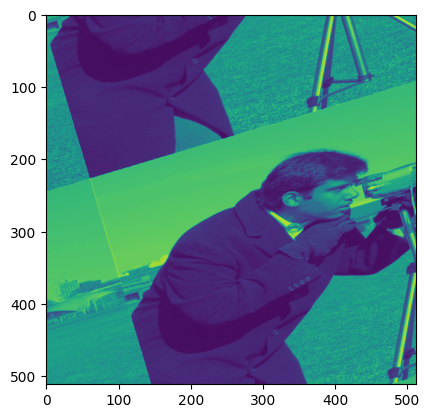

In [95]:
plt.imshow(video[1,0])

In [101]:
downsampled_size = (128, 128)

In [107]:
downsampled_grid = einops.rearrange(torch.nn.functional.interpolate(einops.rearrange(grid, "N H W C -> N C H W"), size=downsampled_size), "N C H W -> N H W C")
if fill_mode == "wrap":
    # Need to do in-place for memory concerns
    grid.add_(1).remainder_(2).subtract_(1)
    fill_mode = "zeros"

image_tensor = einops.repeat(torch.tensor(image, device=device, dtype=torch.float), "H W -> N 1 H W", N=transformation_matrices.shape[0])
downsampled_video_1 = torch.nn.functional.grid_sample(image_tensor, downsampled_grid, interpolation, fill_mode, align_corners=True)
fill_mode = "wrap"

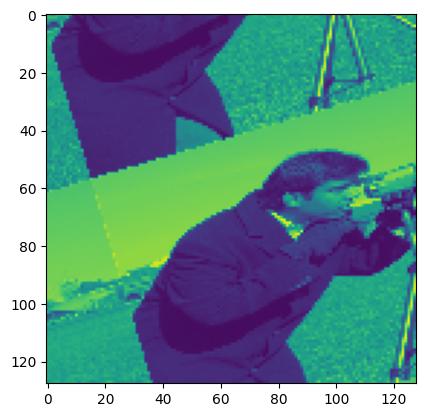

In [109]:
plt.imshow(downsampled_video_1[1,0])

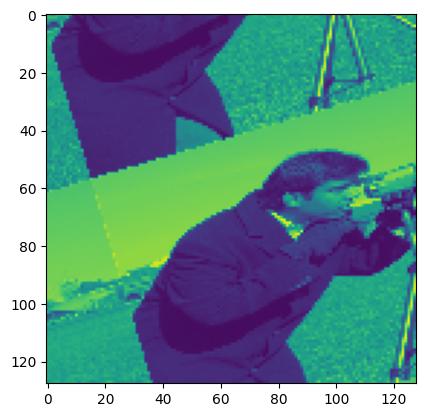

In [113]:
downsampled_video_2 = torch.nn.functional.interpolate(video, size=downsampled_size)
plt.imshow(downsampled_video_2[1,0])

In [126]:
torch.std(downsampled_video_2 - downsampled_video_1)

tensor(0.)